In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import json
from dotmap import DotMap
import pandas as pd
from tqdm.notebook import tqdm

%config InlineBackend.figure_format = 'retina'

# https://www.kaggle.com/datasets/ruchi798/star-wars

In [2]:
episodes = []
factions = []
for i in range(1, 8):
    with open(f'data/interactions/starwars-episode-{i}-interactions-allCharacters.json') as f:
        episodes.append(DotMap(json.load(f)))
    try:
        with open(f'data/factions/factions_{i}.json') as f:
            factions.append(json.load(f))
    except:
        factions.append({})

outcomes = []
with open('data/outcomes.json') as f:
    outcomes = json.load(f)
    outcomes = [v for k, v in outcomes.items()]

In [3]:
name_mappings = []

for i in range(1, 8):
    with open(f'data/characters_mapping/episode_{i}.json') as f:
        name_mappings.append(DotMap(json.load(f)))

In [4]:
networks = []
for i, episode in enumerate(episodes):
    G = nx.Graph()
    to_remove = []
    for node in episode.nodes:
        if len(factions[i]) > 0:
            if node.name in factions[i]['bad']:
                faction = 'bad'
            elif node.name in factions[i]['good']:
                faction = 'good'
            elif node.name in factions[i]['neutral']:
                faction = 'neutral'
            elif node.name in factions[i]['remove']:
                to_remove.append(node.name)
            else:
                raise Exception(f'Unknown faction for {node.name}')
        # if name_mappings[i].get(node.name, '') == '':
        #     to_remove.append(node.name)
        G.add_node(node.name, value=node.value, color=node.colour, faction=faction)
    for link in episode.links:
        G.add_edge((nl:=list(G.nodes))[link.source], nl[link.target], weight=link.value)
    for node in to_remove:
        if node in G.nodes:
            G.remove_node(node)
    G = nx.subgraph(G, max(nx.connected_components(G), key=len))
    networks.append(G)
    print(to_remove)

['PK-4']
['PK-4']
[]
[]
[]
[]
[]


In [5]:
faction_to_color = {
    'bad' : 'tab:red',
    'good' : 'tab:blue',
    'neutral' : 'tab:green',
}

In [6]:
stats = pd.DataFrame(columns=['episode'])
stats.set_index('episode', inplace=True)

def get_stats(G):
    return {
        'nodes': len(G.nodes),
        'edges': len(G.edges),
        'density': nx.density(G),
        'avg_degree': np.mean([degree for node, degree in G.degree]),
        'connectivity': nx.average_node_connectivity(G),
        'diameter': nx.diameter(G),
        'assortativity': nx.degree_pearson_correlation_coefficient(G),
        'efficiency': nx.global_efficiency(G),
        'avg_betweenness_centrality': np.mean([nx.betweenness_centrality(G)[node] for node in G.nodes]),
        'avg_closeness_centrality': np.mean([nx.closeness_centrality(G)[node] for node in G.nodes]),
        'avg_second_order_degree_centrality': np.mean([nx.second_order_centrality(G)[node] for node in G.nodes]),
        'cliques': nx.graph_number_of_cliques(G),
        'avg_clustering': nx.average_clustering(G),
        'mean_rich_club_coefficient': np.mean([v for d, v in nx.rich_club_coefficient(G, normalized=False).items()]),
        'avg_shortest_path_length': nx.average_shortest_path_length(G),
    }

for i, G in enumerate(networks):
    stats.loc[i+1, 'outcome'] = outcomes[i]
    
    for stat, value in get_stats(G).items():
        stats.loc[i+1, f'{stat}'] = value
    
    # Reorganize the columns such that the same stats are next to each other
    stats = stats.reindex(columns=['outcome'] + sorted([c for c in stats.columns if not c == 'outcome'], key=lambda x: '_'.join(x.split('_')[1:])))

    # Replace all NaNs with 0
    stats = stats.fillna(0)

# stats.to_csv('stats.csv')

      outcome  prediction  confidence
Ep 1        1           1    0.999660
Ep 2        1           1    0.991870
Ep 3        0           0    0.989440
Ep 4        1           1    0.999994
Ep 5        0           0    0.999337
Ep 6        1           1    0.990586
Ep 7        1           1    1.000000
Score: 1.0


/var/folders/l_/vnq08k4n0hn498fyp2mcvcsm0000gn/T/ipykernel_30895/2652902370.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(names, rotation=90)


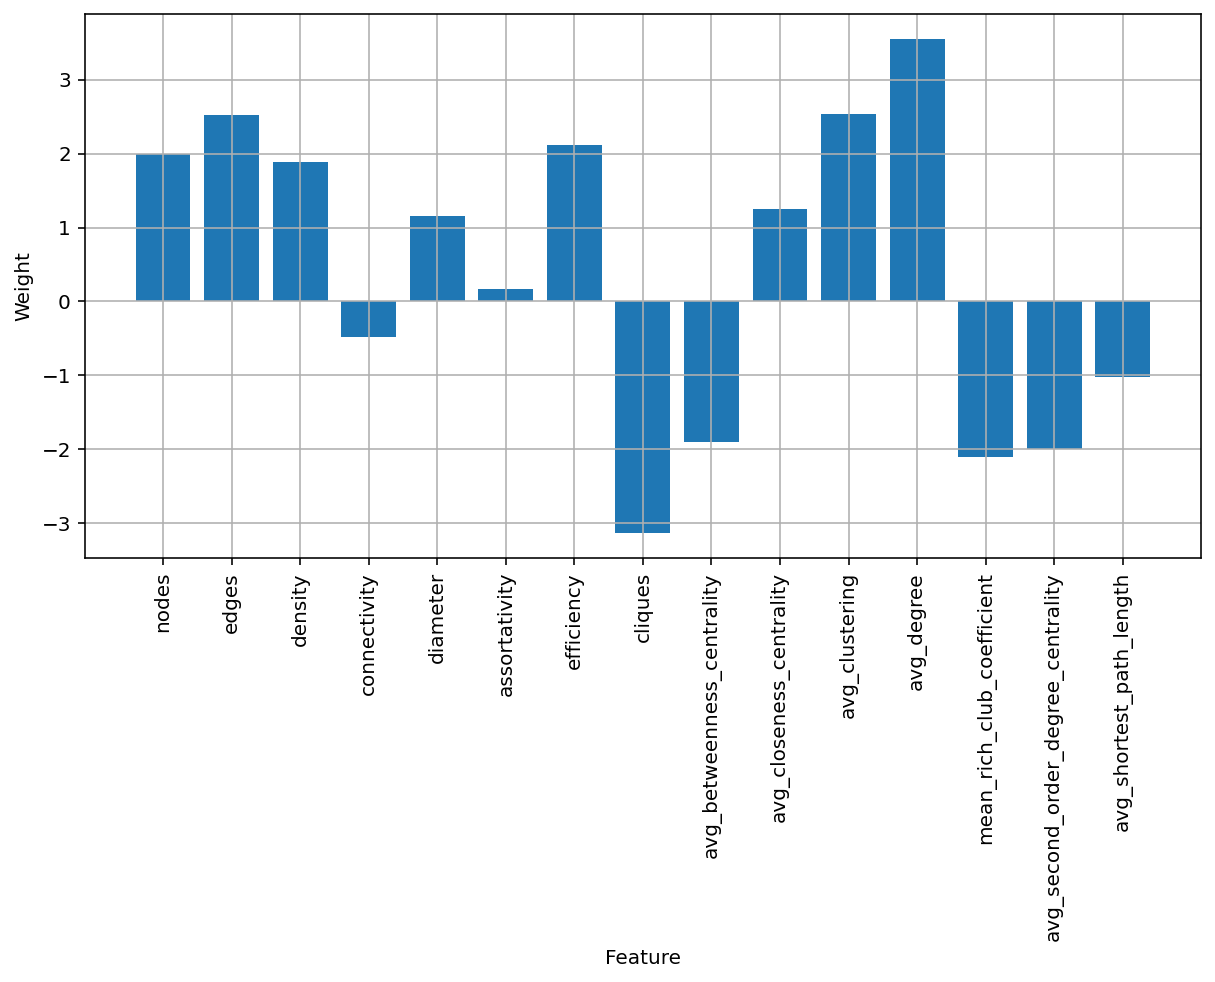

In [7]:
outcome_map = {
    'good' : 1,
    'bad' : 0,
}

X = np.array(stats.drop('outcome', axis=1).values)
Y = stats['outcome'].map(outcome_map).values
names = stats.columns[1:]


# Construct a linear model and optimize with lasso regularization
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression


# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# model = Lasso(alpha=0., max_iter=100000, tol=1e-15)
# model = LinearRegression(positive=True)
model = LogisticRegression(penalty='none', solver='saga', max_iter=10000, tol=1e-4, random_state=42)
model.fit(X, Y)

# Print each outcome and its coefficient
res = pd.DataFrame({'outcome': Y, 'prediction': model.predict(X)}, index=[f'Ep {i+1}' for i in range(len(Y))])
if type(model) == LogisticRegression:
    res['confidence'] = [p[stats['outcome'].map(outcome_map).values[i]] for i, p in enumerate(model.predict_proba(X))]
print(res)
color = '\033[92m' if all((np.array(res['outcome']) > 0) == (np.array(res['prediction']) > 0)) else '\033[91m'
print(f'{color}Score: {model.score(X, Y)}')

# Plot the coefficients
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(names, model.coef_[0] if type(model) == LogisticRegression else model.coef_)
ax.set_xlabel('Feature')
ax.set_ylabel('Weight')
ax.set_xticklabels(names, rotation=90)
ax.grid()
plt.show()

In [8]:
episode_ranks = []

def remove_confidence(G_, node):
    G = G_.copy()
    G.remove_node(node)
    G = nx.subgraph(G, max(nx.connected_components(G), key=len))
    remove_stats = pd.DataFrame()
    for stat, value in get_stats(G).items():
        remove_stats.loc[i+1, f'{stat}'] = value
    remove_stats = remove_stats.reindex(columns=sorted([c for c in remove_stats.columns], key=lambda x: '_'.join(x.split('_')[1:])))
    remove_stats = remove_stats.fillna(0)
    X = np.array(remove_stats.values)
    X = scaler.transform(X)
    confidence = model.predict_proba(X)[0]
    return confidence, len(G.nodes), len(G.edges)



for i, G in tqdm(enumerate(networks), total=len(networks)):
    rank = {}
    outcome = stats['outcome'].map(outcome_map).values[i]
    base_confidence = model.predict_proba(scaler.transform([stats.iloc[i].values[1:]]))[0][outcome]
    node_confidence_importance = []
    # node_new_size = {}
    for node in tqdm(G.nodes, total=len(G.nodes), leave=True, desc=f'Ep {i+1}'):
        confidence, n_nodes, n_edges = remove_confidence(G, node)
        node_confidence_importance.append((node, base_confidence - confidence[outcome]))
        # node_new_size[node] = (n_nodes, n_edges)
    rank['confidence'] = sorted(node_confidence_importance, key=lambda x: x[1], reverse=True)
    # rank['original_size'] = (len(G.nodes), len(G.edges))
    # rank['outcome'] = stats['outcome'].values[i]
    # rank['new_size'] = node_new_size
    rank['closeness'] = sorted([(node, nx.closeness_centrality(G)[node]) for node in G.nodes], key=lambda x: x[1], reverse=True)
    rank['betweenness'] = sorted([(node, nx.betweenness_centrality(G)[node]) for node in G.nodes], key=lambda x: x[1], reverse=True)
    episode_ranks.append(rank)

  0%|          | 0/7 [00:00<?, ?it/s]

Ep 1:   0%|          | 0/37 [00:00<?, ?it/s]

Ep 2:   0%|          | 0/32 [00:00<?, ?it/s]

Ep 3:   0%|          | 0/24 [00:00<?, ?it/s]

Ep 4:   0%|          | 0/21 [00:00<?, ?it/s]

Ep 5:   0%|          | 0/21 [00:00<?, ?it/s]

Ep 6:   0%|          | 0/20 [00:00<?, ?it/s]

Ep 7:   0%|          | 0/27 [00:00<?, ?it/s]

In [10]:
movies = pd.read_pickle('data/kaggle/credits_movie.pkl')

episode_to_titleId = ['tt0120915', 'tt0121765', 'tt0121766', 'tt0076759', 'tt0080684', 'tt0086190', 'tt2488496']
episode_dates = [movies[movies['imdb_id'] == id]['release_date'].values[0] for id in episode_to_titleId]

movie_net = pd.read_pickle('data/kaggle/nets/full.gpickle')

In [11]:
from functools import partial

episode_networks = []
for i, date in enumerate(episode_dates):
    ep_net = nx.subgraph_view(
        movie_net,
        filter_node=partial(lambda x, g, d: g.nodes[x]['date'] <= d, g=movie_net, d=date),
        filter_edge=partial(lambda x,y, g, d: g.edges[x,y]['date'] <= d, g=movie_net, d=date)
    )
    episode_networks.append(ep_net)

In [ ]:
roman = {1: 'I', 2: 'II', 3: 'III', 4: 'IV', 5: 'V', 6: 'VI', 7: 'VII'}

for i, ep_n in enumerate(episode_networks):
    print(f'{roman[i+1]} &', ' & '.join([
        str(num_nodes:=len(ep_n.nodes)),
        str(len(ep_n.edges)),
        str(np.mean(degs:=[d for n, d in tqdm(ep_n.degree(), total=num_nodes)])),
        str(np.max(degs)),
    ]), '\\\\\\hline')

In [71]:
# get the node with the highest degree
max(G.degree, key=lambda x: x[1])

((121323, 'Bess Flowers'), 3371)

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax = ax.flatten()

for i, ep_n in enumerate(episode_networks):
    degree_df = np.unique(sorted([d for _, d in tqdm(ep_n.degree(), total=len(ep_n))]), return_counts=True)
    sum_deg = np.sum(degree_df[1])
    ax_i = i if i < 6 else 7
    ax[ax_i].loglog(degree_df[0], degree_df[1] / sum_deg, '.', label='Original Data')
    ax[ax_i].loglog(degree_df[0], 5e1 / degree_df[0]**2.2, label='Fit Line')
    ax[ax_i].set_xlabel('Degree k')
    ax[ax_i].set_ylabel('$P(X=k)$')
    ax[ax_i].set_title(f'Episode {roman[i+1]}')
    ax[ax_i].legend()
    ax[ax_i].grid()

fig.tight_layout()
fig.delaxes(ax[6])
fig.delaxes(ax[8])

fig.show()

In [44]:
import time

def get_ranking(episode, G):
    movie_ep = movies[movies.imdb_id == episode_to_titleId[episode]]
    characters = {c['character']: (c['id'], c['name']) for c in movie_ep.cast.values[0]}
    episode_characters = {k:characters[v] for k,v in name_mappings[episode].items() if v in characters}

    # movie_rank_closeness = sorted([(k, nx.closeness_centrality(G, u=v)) for k,v in tqdm(episode_characters.items(), total=len(episode_characters), leave=True, desc=f'Ep {episode+1}')], key=lambda x: x[1], reverse=True)
    start = time.time()
    betweenness = nx.betweenness_centrality(G, k=1000, normalized=False, seed=42)
    # betweenness = nx.betweenness_centrality(G, k=1, normalized=False, seed=42)
    print(f'Ep {roman[episode+1]} - {time.time() - start}')
    movie_rank_betweenness = sorted([(k, betweenness[v]) for k,v in episode_characters.items()], key=lambda x: x[1], reverse=True)

    return episode, {
        # 'closeness': movie_rank_closeness,
        'betweenness': movie_rank_betweenness
    }



from concurrent.futures import ThreadPoolExecutor

movie_rank_futures = []
with ThreadPoolExecutor(max_workers=7) as executor:
    for episode, G in enumerate(episode_networks):
        movie_rank_futures.append(executor.submit(get_ranking, episode, G))
movie_rank_results = sorted([f.result() for f in movie_rank_futures], key=lambda x: x[0])

import pickle
movie_ranks = [{'closeness':r['closeness']} for r in pickle.load(open('movie_ranks.pkl', 'rb'))]

for episode, rank_results in movie_rank_results:
    for rank_type, rank in rank_results.items():
        movie_ranks[episode][rank_type] = rank

KeyboardInterrupt: 

In [37]:
base_episode_metric = 'confidence'

In [38]:
from scipy.stats import kendalltau, spearmanr

def get_correlation(rank, base):
    tau, p_tau = kendalltau([r[0] for r in rank], [r[0] for r in base], method='exact')
    rho, p_rho = spearmanr([r[0] for r in rank], [r[0] for r in base])

    return tau, p_tau, rho, p_rho

correlations = pd.DataFrame()
for episode, rank in enumerate(movie_ranks):
    movie_ep = movies[movies.imdb_id == episode_to_titleId[episode]]
    characters = {c['character']: (c['id'], c['name']) for c in movie_ep.cast.values[0]}
    episode_characters = {k:characters[v] for k,v in name_mappings[episode].items() if v in characters}
    base = [c for c in episode_ranks[episode][base_episode_metric] if c[0] in episode_characters]
    for metric in movie_ranks[0].keys():
        tau, p_tau, rho, p_rho = get_correlation(rank[metric], base)
        correlations.loc[f'Episode {roman[episode+1]}', f'Kendall tau {metric}/{base_episode_metric}'] = tau
        correlations.loc[f'Episode {roman[episode+1]}', f'Kendall p {metric}/{base_episode_metric}'] = p_tau
        correlations.loc[f'Episode {roman[episode+1]}', f'Spearman rho {metric}/{base_episode_metric}'] = rho
        correlations.loc[f'Episode {roman[episode+1]}', f'Spearman p {metric}/{base_episode_metric}'] = p_rho

correlations

,Kendall tau closeness/confidence,Kendall p closeness/confidence,Spearman rho closeness/confidence,Spearman p closeness/confidence
Episode I,-0.083779,0.498190,-0.141024,0.426304
Episode II,0.037037,0.799177,0.060208,0.760868
Episode III,-0.047619,0.788420,-0.144156,0.533006
Episode IV,-0.111111,0.549812,-0.149639,0.553423
Episode V,-0.038095,0.834682,-0.077922,0.737075
Episode VI,-0.021053,0.923502,-0.069173,0.771985
Episode VII,0.027692,0.861456,0.046154,0.822847


In [39]:
top_correlations = pd.DataFrame()
top_n = 5
for episode, rank in enumerate(movie_ranks):
    movie_ep = movies[movies.imdb_id == episode_to_titleId[episode]]
    characters = {c['character']: (c['id'], c['name']) for c in movie_ep.cast.values[0]}
    episode_characters = {k:characters[v] for k,v in name_mappings[episode].items() if v in characters}
    base = [c for c in episode_ranks[episode][base_episode_metric] if c[0] in episode_characters]
    for metric in movie_ranks[0].keys():
        tau, p_tau, rho, p_rho = get_correlation(rank[metric][:top_n], base[:top_n])
        top_correlations.loc[f'Episode {roman[episode+1]}', f'Kendall tau {metric}/{base_episode_metric}'] = tau
        top_correlations.loc[f'Episode {roman[episode+1]}', f'Kendall p {metric}/{base_episode_metric}'] = p_tau
        top_correlations.loc[f'Episode {roman[episode+1]}', f'Spearman rho {metric}/{base_episode_metric}'] = rho
        top_correlations.loc[f'Episode {roman[episode+1]}', f'Spearman p {metric}/{base_episode_metric}'] = p_rho

top_correlations

,Kendall tau closeness/confidence,Kendall p closeness/confidence,Spearman rho closeness/confidence,Spearman p closeness/confidence
Episode I,0.0,1.000000,-0.1,0.872889
Episode II,0.2,0.816667,0.0,1.000000
Episode III,-0.6,0.233333,-0.7,0.188120
Episode IV,0.0,1.000000,0.0,1.000000
Episode V,0.0,1.000000,0.1,0.872889
Episode VI,0.8,0.083333,0.9,0.037386
Episode VII,0.0,1.000000,-0.1,0.872889
